In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [14]:
class PerceptronMulticapa:
    """
    Clase para implementar un Perceptrón Multicapa (MLP) desde cero,
    con optimización Adam para el descenso del gradiente.

    Parámetros:
    - capas: lista con el número de neuronas por capa (incluyendo entrada y salida)
    - eta: tasa de aprendizaje (learning rate)
    - beta1: coeficiente de decaimiento para la primera media móvil de Adam
    - beta2: coeficiente de decaimiento para la segunda media móvil de Adam
    - epsilon: pequeño valor para evitar división por cero en Adam
    """

    def __init__(self, capas, eta=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.capas = capas
        self.eta = eta
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.pesos, self.bias = self.inicializar_pesos()
        self.m, self.v = self.inicializar_momentos()
        self.t = 0  # contador de iteraciones para Adam
    @staticmethod
    def sigmoide(z):
        return 1 / (1 + np.exp(-z))

    @staticmethod
    def derivada_sigmoide(a):
        return a * (1 - a)

    def inicializar_pesos(self):
        """Inicialización Xavier/Glorot para sigmoid/tanh"""
        pesos = []
        bias = []
        for i in range(len(self.capas) - 1):
            limit = np.sqrt(6 / (self.capas[i] + self.capas[i+1]))
            pesos.append(np.random.uniform(-limit, limit, 
                                        (self.capas[i], self.capas[i+1])))
            bias.append(np.zeros((1, self.capas[i+1])))
        return pesos, bias

    def inicializar_momentos(self):
        """
        Inicializa vectores m (media móvil) y v (varianza) para Adam, a ceros,
        con la misma forma que pesos y bias.
        
        Returns:
            m (list), v (list): listas de matrices/arrays con ceros
        """
        m = [np.zeros_like(p) for p in self.pesos]
        v = [np.zeros_like(p) for p in self.pesos]
        m_b = [np.zeros_like(b) for b in self.bias]
        v_b = [np.zeros_like(b) for b in self.bias]
        return (m, m_b), (v, v_b)
        
    def forward(self, X):
        """
        Realiza la propagación hacia delante a través de todas las capas.

        Parámetros:
        - X: array numpy de dimensión (n_muestras, n_entradas),
          datos de entrada al perceptrón.

        Retorna:
        - activaciones: lista con las activaciones por cada capa,
          incluyendo la capa de entrada y todas las ocultas y salida.
        - zetas: lista con los valores lineales (Wx + b) de cada capa,
          necesarios para el cálculo del gradiente en la retropropagación.
        """
        activaciones = [X]
        zetas = []

        # para cada capa (menos la de entrada)
        for i in range(len(self.pesos)):
            # producto lineal Wx + b
            z = np.dot(activaciones[-1], self.pesos[i]) + self.bias[i]
            zetas.append(z)
            # activación con función sigmoide
            a = self.sigmoide(z)
            activaciones.append(a)

        return activaciones, zetas
    def backward(self, activaciones, zetas, Y):
        """
        Calcula el gradiente de la función de pérdida respecto a
        pesos y biases usando retropropagación.

        Parámetros:
        - activaciones: lista con activaciones de cada capa, calculadas en forward.
        - zetas: lista con valores lineales (Wx + b) de cada capa, calculados en forward.
        - Y: array numpy con las etiquetas verdaderas, dimensión (n_muestras, n_salidas)

        Retorna:
        - grad_pesos: lista con los gradientes respecto a los pesos.
        - grad_bias: lista con los gradientes respecto a los biases.
        """
        # Número de muestras
        m = Y.shape[0]

        # Inicializamos listas para los gradientes con ceros
        grad_pesos = [np.zeros_like(p) for p in self.pesos]
        grad_bias = [np.zeros_like(b) for b in self.bias]

        # Calculamos delta para la capa de salida: (a - y) * derivada_sigmoide(z)
        delta = (activaciones[-1] - Y) * self.derivada_sigmoide(activaciones[-1])

        # Retropropagamos desde la última capa hasta la primera oculta
        for i in reversed(range(len(self.pesos))):
            # Gradientes para pesos y bias
            grad_pesos[i] = np.dot(activaciones[i].T, delta) / m
            grad_bias[i] = np.sum(delta, axis=0, keepdims=True) / m

            # Si no es la primera capa, calculamos delta para la capa anterior
            if i != 0:
                delta = np.dot(delta, self.pesos[i].T) * self.derivada_sigmoide(activaciones[i])

        return grad_pesos, grad_bias
    def actualizar_parametros(self, grad_pesos, grad_bias):
        """
        Actualiza pesos y biases usando el optimizador Adam.

        Parámetros:
        - grad_pesos: lista con gradientes de los pesos calculados en backward.
        - grad_bias: lista con gradientes de los biases calculados en backward.

        Adam actualiza cada parámetro con momentos de primer y segundo orden,
        con corrección de sesgo para mejorar la convergencia y estabilidad.
        """
        self.t += 1  # Incrementar contador de iteraciones

        for i in range(len(self.pesos)):
            # Actualización momentos primer orden (media móvil)
            self.m[0][i] = self.beta1 * self.m[0][i] + (1 - self.beta1) * grad_pesos[i]
            self.m[1][i] = self.beta1 * self.m[1][i] + (1 - self.beta1) * grad_bias[i]

            # Actualización momentos segundo orden (varianza móvil)
            self.v[0][i] = self.beta2 * self.v[0][i] + (1 - self.beta2) * (grad_pesos[i] ** 2)
            self.v[1][i] = self.beta2 * self.v[1][i] + (1 - self.beta2) * (grad_bias[i] ** 2)

            # Corrección de sesgo
            m_hat_pesos = self.m[0][i] / (1 - self.beta1 ** self.t)
            m_hat_bias = self.m[1][i] / (1 - self.beta1 ** self.t)
            v_hat_pesos = self.v[0][i] / (1 - self.beta2 ** self.t)
            v_hat_bias = self.v[1][i] / (1 - self.beta2 ** self.t)

            # Actualización de pesos y biases
            self.pesos[i] -= self.eta * m_hat_pesos / (np.sqrt(v_hat_pesos) + self.epsilon)
            self.bias[i] -= self.eta * m_hat_bias / (np.sqrt(v_hat_bias) + self.epsilon)
    
    def categorical_crossentropy(self, Y_pred, Y_true):
        """
        Categorical cross-entropy para clasificación multiclase.
        Y_true: one-hot encoded (n_samples, n_classes)
        Y_pred: probabilidades (n_samples, n_classes)
        """
        m = Y_true.shape[0]
        epsilon = 1e-10
        Y_pred = np.clip(Y_pred, epsilon, 1 - epsilon)
        loss = -np.sum(Y_true * np.log(Y_pred)) / m
        return loss

    def entrenar(self, X, Y, epochs=1000, verbose=True):
        """
        Entrena el perceptrón multicapa con los datos dados.

        Parámetros:
        - X: array numpy con datos de entrada, shape (n_muestras, n_entradas).
        - Y: array numpy con etiquetas binarias, shape (n_muestras, n_salidas).
        - epochs: número de épocas o iteraciones completas sobre el conjunto.
        - verbose: si es True, muestra la pérdida periódicamente.
        """
        for epoca in range(1, epochs + 1):
            # Paso forward
            activaciones, zetas = self.forward(X)
            Y_pred = activaciones[-1]

            # Calc pérdida
            perdida = self.funcion_perdida(Y_pred, Y)

            # Paso backward
            grad_pesos, grad_bias = self.backward(activaciones, zetas, Y)

            # Actualización parámetros
            self.actualizar_parametros(grad_pesos, grad_bias)

            if verbose and epoca % 100 == 0:
                print(f"Época {epoca}, Pérdida: {perdida:.4f}")
   
    def precision(self, Y_pred, Y_true):
        """
        Accuracy para clasificación multiclase.
        Convierte probabilidades y one-hot a etiquetas.
        """
        pred_labels = np.argmax(Y_pred, axis=1)
        true_labels = np.argmax(Y_true, axis=1)
        return np.mean(pred_labels == true_labels)
    

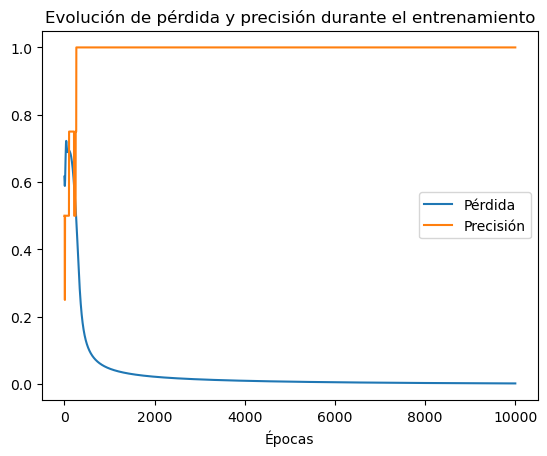

In [16]:
# Supongamos un conjunto simple XOR para clasificación binaria
X = np.array([[0,0],[0,1],[1,0],[1,1]])
Y = np.array([[1,0],[0,1],[0,1],[1,0]])  # One-hot para 2 clases

# Instancia del perceptrón multicapa
mlp = PerceptronMulticapa(capas=[2, 4, 2], eta=0.01)

# Variables para almacenar pérdida por época
epocas = 10000
perdidas = []

precisiones = []

for epoca in range(epocas):
    activaciones, zetas = mlp.forward(X)
    perdida = mlp.categorical_crossentropy(activaciones[-1], Y)
    precis = mlp.precision(activaciones[-1], Y)

    perdidas.append(perdida)
    precisiones.append(precis)

    grad_pesos, grad_bias = mlp.backward(activaciones, zetas, Y)
    mlp.actualizar_parametros(grad_pesos, grad_bias)

# Visualizamos pérdida y precisión
plt.plot(perdidas, label="Pérdida")
plt.plot(precisiones, label="Precisión")
plt.xlabel('Épocas')
plt.legend()
plt.title('Evolución de pérdida y precisión durante el entrenamiento')
plt.show()


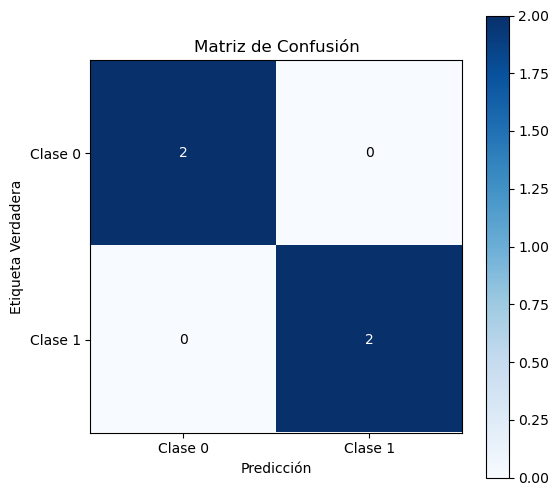

In [17]:
def matriz_confusion_np(y_true, y_pred, clases, cmap=plt.cm.Blues):
    """
    Calcula y visualiza la matriz de confusión sin dependencias externas.

    Parámetros:
    - y_true: etiquetas verdaderas (array numpy).
    - y_pred: etiquetas predichas (array numpy).
    - clases: lista o array con nombres de las clases.
    - cmap: mapa de color para la gráfica (opcional).
    """
    n_clases = len(clases)
    cm = np.zeros((n_clases, n_clases), dtype=int)

    for t, p in zip(y_true.flatten(), y_pred.flatten()):
        cm[int(t), int(p)] += 1

    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Matriz de Confusión')
    plt.colorbar()
    tick_marks = np.arange(n_clases)
    plt.xticks(tick_marks, clases)
    plt.yticks(tick_marks, clases)
    plt.xlabel('Predicción')
    plt.ylabel('Etiqueta Verdadera')

    thresh = cm.max() / 2.
    for i in range(n_clases):
        for j in range(n_clases):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.show()


# Supón que activaciones es la salida (probabilidades)
y_true_labels = np.argmax(Y, axis=1)
y_pred_labels = np.argmax(activaciones[-1], axis=1)

matriz_confusion_np(y_true=y_true_labels, y_pred=y_pred_labels, clases=['Clase 0', 'Clase 1'])



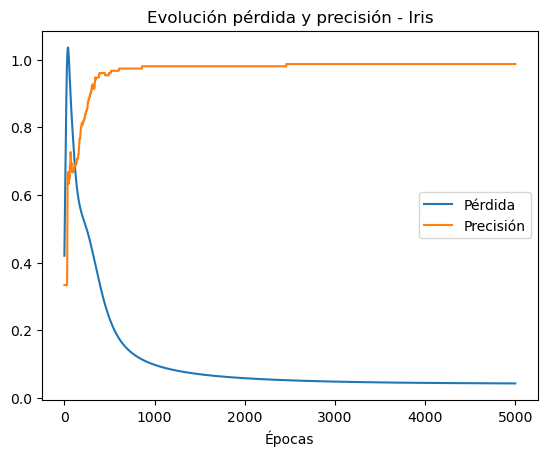

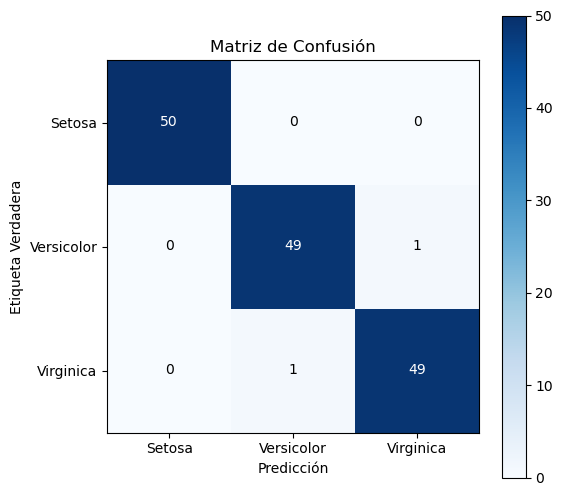

NameError: name 'plot_decision_boundary' is not defined

In [ ]:

# Cargar y preparar datos Iris
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
columnas = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']
iris_df = pd.read_csv(url, names=columnas)

clases_map = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
iris_df['class'] = iris_df['class'].map(clases_map)

X = iris_df.iloc[:, :-1].values
y = iris_df['class'].values

# Normalización min-max
X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

# Codificación one-hot
Y = np.zeros((y.size, y.max()+1))
Y[np.arange(y.size), y] = 1

# Aquí debes tener definida e importada la clase PerceptronMulticapa bien con sigmoide y derivada incluidas

# Crear la red 4-8-3
mlp = PerceptronMulticapa(capas=[4, 8, 3], eta=0.01)

epocas = 5000
perdidas = []
precisiones = []

for epoca in range(epocas):
    activaciones, zetas = mlp.forward(X)
    perdida = mlp.categorical_crossentropy(activaciones[-1], Y)
    perdidas.append(perdida)
    precision = mlp.precision(activaciones[-1], Y)
    precisiones.append(precision)
    grad_pesos, grad_bias = mlp.backward(activaciones, zetas, Y)
    mlp.actualizar_parametros(grad_pesos, grad_bias)

# Graficar pérdida y precisión
plt.plot(perdidas, label='Pérdida')
plt.plot(precisiones, label='Precisión')
plt.xlabel('Épocas')
plt.legend()
plt.title('Evolución pérdida y precisión - Iris')
plt.show()

# Preparar etiquetas para matriz de confusión
y_true_labels = np.argmax(Y, axis=1)
y_pred_labels = np.argmax(activaciones[-1], axis=1)

# Función definida matriz_confusion_np() para matriz de confusión sin sklearn
matriz_confusion_np(y_true=y_true_labels, y_pred=y_pred_labels, clases=['Setosa', 'Versicolor', 'Virginica'])

# Función definida plot_decision_boundary() para frontera de decisión 2D con primeras 2 características
plot_decision_boundary(X[:, :2], Y, mlp, feature_names=['Sepal length', 'Sepal width'])
